In [1]:
import os,sys
sys.path.append('/home/aashish/PhD/Somospie/Src_SOMOSPIE-jay_dev/GEOtiled_Refactor/somospie_lib/src')
sys.path.append('/home/aashish/miniconda3/envs/geotiled/lib/python3.12/site-packages')
# sys.path.append("/home/aashish/.local/lib/junto/bin")
sys.path

['/home/aashish/PhD/Somospie/Src_SOMOSPIE-jay_dev/GEOtiled_Refactor/geotiled_notebook',
 '/usr/lib/python310.zip',
 '/usr/lib/python3.10',
 '/usr/lib/python3.10/lib-dynload',
 '',
 '/home/aashish/.local/lib/python3.10/site-packages',
 '/usr/local/lib/python3.10/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/home/aashish/PhD/Somospie/Src_SOMOSPIE-jay_dev/GEOtiled_Refactor/somospie_lib/src',
 '/home/aashish/miniconda3/envs/geotiled/lib/python3.12/site-packages']

# GEOtiled: A Scalable Workflow for Generating Large Datasets of High-Resolution Terrain Parameters
# Refactored Package - November 2023

Terrain parameters such as slope, aspect and hillshading can be computed from a Digital Elevation Model (DEM) which is a representation of elevation data of the surface of the earth. In SOMOSPIE these terrrain parameters are used to downscale satellite-derived soil moisture data.

GEOtiled comprises three stages: (i) the partition of the DEM into tiles, each with a buffer region; (ii) the computation of the terrain parameters for each individual tile; and finally, (iii) the generation of a mosaic for each parameter from the tiles by averaging the values of the pixels that overlap between the tiles (i.e., pixels within the buffer regions). 

<p align="center">
<img src="../../somospie_pngs/geotiled.png" width="500"/>
</p>

<p align="center">
<b>Figure 1: </b>GEOtiled workflow.
</p>

This notebook uses DEMs from [USGS 3DEP products](https://www.usgs.gov/3d-elevation-program/about-3dep-products-services) to compute 3 topographic parameters: Aspect, Hillshading and Slope.

Before running the workflow on this notebook, go to [USGS Data Download Application](https://apps.nationalmap.gov/downloader/#/elevation) and use the map to look for available DEM data. Once you have selected a specific region and resolution, you can get a txt file with all the individual download links for the tiles corresponding to your selection. This txt file will serve as input to this notebook which uses the links to download the tiles and compute the parameters.

The terrain parameters are by default generated as GeoTIFF files, the option to change their format and stack them if needed is included at the end.

-------------

## What has changed in the packaged version?

GEOtiled is now available as an importable Pypi package in order to simplify usage. With this change comes a few updates and new features.

1. The library is now imported using syntax similar to the code below. 
2. Downloading DEM data is now simpler with `fetch_dem()`. Simply specify a bounding box of coordinates that you would like, and the function will generate a txt file of download links as described above. Database options can be found [here](https://apps.nationalmap.gov/tnmaccess/#/product) 
3. There is a new powerful visualization for viewing GEOTiff files called `generate_img()`. There are a large number of configurable parameters with descriptions available in the DocStrings.
4. All functions now have DocStrings detailing usage. These are used to generate web documentation using [Sphinx](https://www.sphinx-doc.org/en/master/). 
5. The file downloading function has been tweaked to include a progress bar.
6. Several other small changes. Feel free to take a look at the [source code](https://github.com/TauferLab/Src_SOMOSPIE/tree/jay_dev/SOMOSPIE_Refactor/somospie_lib/src/somospie_lib). 

----------

## Environment setup
Run the following code boxes to set the working directories and packages necessary for this workflow.

In [58]:
from somospie_lib import geotiled as gt
from somospie_lib import geoextras as ge
from pathlib import Path
import glob
import os
import shutil
import time
import multiprocessing
import matplotlib.pyplot as plt
import OpenVisus as ov
import numpy as np
start_time=time.time()

#To silence a deprecation warning. 
gt.gdal.UseExceptions()

### Settings
Here, we are setting all of the file names and various parameters for the workflow.
Descriptions for each setting are available as in-line comments in the code

In [3]:
download_list = "./download_urls.txt" #Where the list of download links will be stored
root_output_folder = './geotiled/' #root folder where geotiled will store data
n_tiles = 16 #Number of tiles that are generated for parameter computation
dem_tiles_dir_name = "tiles" #Folder where downloaded DEM tiles will be saved
param_tiles_dir_name = "elevation_tiles" #Folder where computation tiles will be saved. 
gcs_name = "gcs.tif" #Name for the mosaicked DEM
pcs_name = "pcs.tif" #Name for the projected DEM
shapefile = ["../misc_data/shp_files/TN/STATEFP_47.shp"] #Shapefile for Visualization
region_bounding_box = {"xmin": -90.4,"ymin": 34.8,"xmax": -81.55,"ymax": 36.8} #For `fetch_dem`. X=Longitude Y=Latitude. Determine bounding coordinates by looking at a map.

#### Generating directories from settings

Run this after changing the settings. This generates the directories and the absolute file paths for files used in GEOtiled. 

In [4]:
#Fetching Data
tiles_folder = os.path.join(root_output_folder, dem_tiles_dir_name)
Path(root_output_folder).mkdir(parents=True, exist_ok=True)
Path(tiles_folder).mkdir(parents=True, exist_ok=True)

#Setting up for parameter computation
gcs = os.path.join(root_output_folder,gcs_name)
pcs = os.path.join(root_output_folder,pcs_name)
elevation_tiles = os.path.join(root_output_folder, param_tiles_dir_name)
Path(elevation_tiles).mkdir(parents=True, exist_ok=True)

#Computing Parameters
aspect_tiles = os.path.join(root_output_folder, 'aspect_tiles')
hillshading_tiles = os.path.join(root_output_folder, 'hillshading_tiles')
slope_tiles = os.path.join(root_output_folder, 'slope_tiles')
Path(aspect_tiles).mkdir(parents=True, exist_ok=True)
Path(hillshading_tiles).mkdir(parents=True, exist_ok=True)
Path(slope_tiles).mkdir(parents=True, exist_ok=True)

----------
## Pre-processing of the DEM

### Fetching Data
Using two *new* GEOTiled functions, `fetch_dem()` and `download_files()`, getting the elevation data for the workflow is a simple task of defining the bounding coordinates of the desired geographic region.

`fetch_dem()` Interfaces directly with the USGS API to pull elevation data given a bounding box of coordinates.
After getting the URLs for the data, the user will have the option to either save them to a .txt file if they want to be able to use the data multiple times or they can choose to immediately download them. 

`download_files()` downloads a selection of files given a list of URLs. 
The list can be input as a filename that the function will read or optionally a Python List of Strings containing the URLs.
As an ease-of-life feature, the download function includes an informative progress bar. 

In [5]:
gt.fetch_dem(bbox=region_bounding_box,txtPath=download_list, dataset="National Elevation Dataset (NED) 1 arc-second Current")
gt.download_files(download_list, tiles_folder)

./download_urls.txt


Downloading: 100%|█████████████████████████████████████████████| 1.72G/1.72G [03:32<00:00, 8.10MB/s]


### Setting up for parameter computation
Now, we will be creating a mosaic of the tiles downloaded previously and reprojecting them to be in a proper format for parameter computation.

This section uses two key functions- `build_mosaic` and `reproject`.

`build_mosaic` creates a mosaic from a list of geo-tiles. It is an integral part of the GEOTILED workflow and is used for merging tiles into a single mosaic file.

`reproject` reprojects a given GeoTIFF raster dataset from its original coordinate system to a new specified projection. 

In [6]:
raster_list = glob.glob(tiles_folder + '/*')

gt.build_mosaic(raster_list, gcs)

# Optional: delete all tiles after building mosaic.
shutil.rmtree(tiles_folder)
# Optional: remove vertex data file. 
os.remove("./merged.vrt")

0...10...20...30...40...50...60...70...80...90...

Reprojecting our data from the `Global Coordinate System` (GCS) to a `Projected Coordinate System` (PCS). In this case, we will be using `EPSG:9822` which is `Albers Conic Equal Area` projection. 

In [7]:
gt.reproject(gcs, pcs, "EPSG:9822")

# Optional: Remove mosaicked DEM. 
os.remove(gcs)

100 - done.
0...10...20...30...40..

## Computing Parameters with GEOtiled
In this section, we will take the generated elevation data and compute aspect, hillshading, and slope from it. This is also generally the same as the original workflow with the addition of band naming. 

This section has three more important functions- `crop_into_tiles()`, `build_mosaic_filtered()`, and `compute_geotiled()`.

`crop_into_tiles()` splits a geotiff file into n number of tiles. This is an important preprocessing step to facilitate parameter computation.

`compute_geotiled()` is the primary component of the GEOTiled library. This function uses the GDAL library to compute terrain parameters like slope, aspect, and hillshading from a provided elevation model in .tif format.

Finally, `build_mosaic_filtered()` is similar to `build_mosaic()` except it has extra logic to handle averaging when regions overlap.

In [8]:
gt.crop_into_tiles(pcs, elevation_tiles, n_tiles)

glob_of_tiles = glob.glob(elevation_tiles + '/*.tif')

.50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90..

We have now split our data into 16 individual tiles (defined by `n_tiles`). We are ready to compute the terrain parameters. 

In [9]:
pool = multiprocessing.Pool(processes=n_tiles) 
pool.map(gt.compute_geotiled, sorted(glob.glob(elevation_tiles + '/*.tif')))

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [10]:
gt.build_mosaic_filtered(sorted(glob.glob(aspect_tiles + '/*.tif')), os.path.join(root_output_folder, 'aspect.tif'))
gt.build_mosaic_filtered(sorted(glob.glob(hillshading_tiles + '/*.tif')), os.path.join(root_output_folder,'hillshading.tif'))
gt.build_mosaic_filtered(sorted(glob.glob(slope_tiles + '/*.tif')), os.path.join(root_output_folder, 'slope.tif'))


shutil.rmtree(aspect_tiles)
shutil.rmtree(hillshading_tiles)
shutil.rmtree(slope_tiles)
shutil.rmtree(elevation_tiles)

## Visualizing the Results

This section highlights the new visualization function `generate_img()`.

`generate_img()` is a customizable user visualization function designed to give users quick and high quality visualizations for their geoTIFF data. There are a wide array of keyword arguments that can be used. For example, "downsample" will scale the data down by a certain factor, speeding up the visualization process. Each parameter has a description in the DocStrings, so be sure to read through those to get an idea of the full capability of the function. 


Reprojecting..
.100 - done.
0...10...20...30...40...50..Cropping with combined shapefiles...
.60...70...80...90...Done.
Reading in tif for visualization...
Done.
Plotting data...
Done. (image should appear soon...)
Reprojecting..
100 - done.
0...10...20...30...40...50...Cropping with combined shapefiles...
60...70...80...90...Done.
Reading in tif for visualization...
Done.
Plotting data...
Done. (image should appear soon...)
Reprojecting..
100 - done.
0...10...20...30...40...50..Cropping with combined shapefiles...
.60...70...80...90...Done.
Reading in tif for visualization...
Done.
Plotting data...
Done. (image should appear soon...)
Reprojecting..
100 - done.
0...10...20...30...40...50..Cropping with combined shapefiles...
.60...70...80...90...Done.
Reading in tif for visualization...
Done.
Plotting data...
Done. (image should appear soon...)


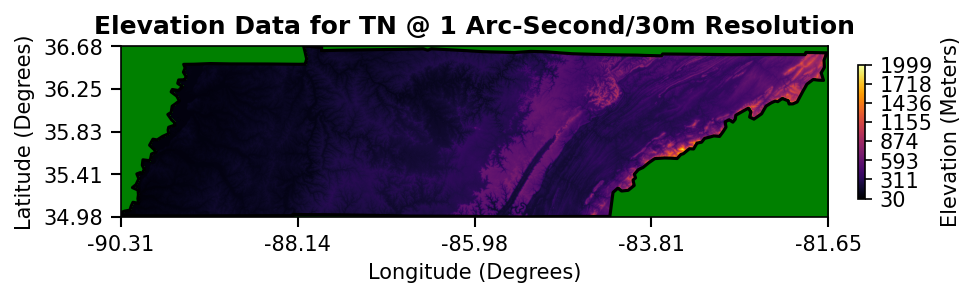

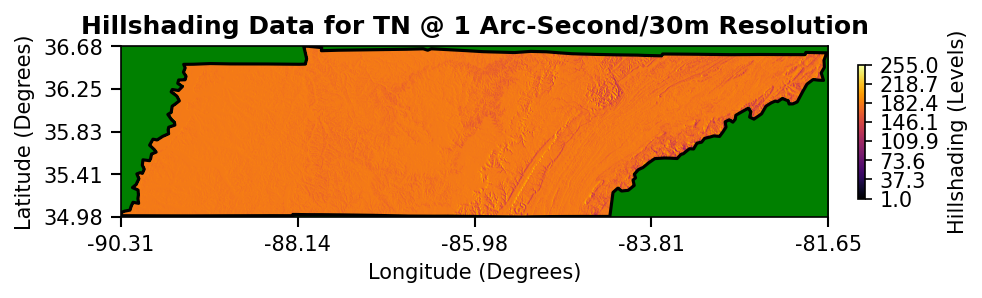

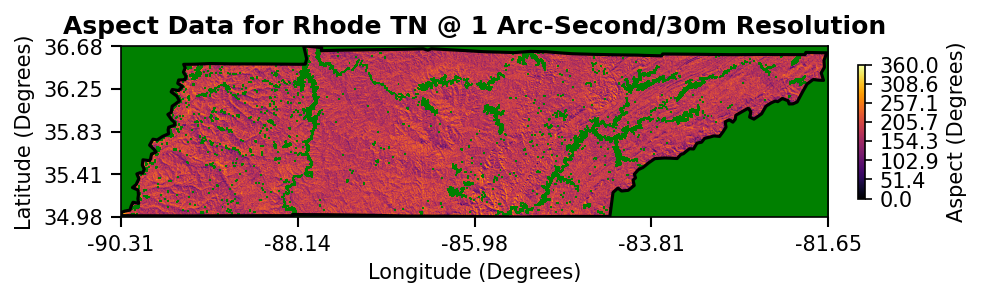

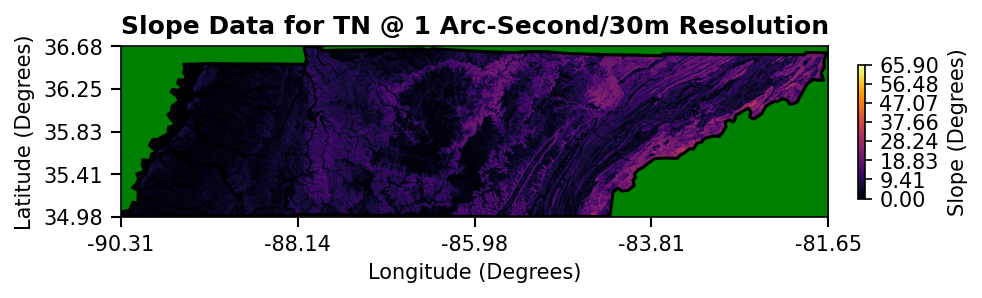

In [11]:
hill = os.path.join(root_output_folder, 'hillshading.tif')
aspect = os.path.join(root_output_folder, 'aspect.tif')
slope = os.path.join(root_output_folder, 'slope.tif')


pcs_array=gt.generate_img(pcs,    downsample=5, reproject_gcs=True, shp_files=shapefile, title="Elevation Data for TN @ 1 Arc-Second/30m Resolution",    zunit="Meter",   xyunit="Degree", ztype="Elevation",   crop_shp=True) 
hill_array=gt.generate_img(hill,   downsample=5, reproject_gcs=True, shp_files=shapefile, title="Hillshading Data for TN @ 1 Arc-Second/30m Resolution",  zunit="Level",   xyunit="Degree", ztype="Hillshading", crop_shp=True)
aspect_array=gt.generate_img(aspect, downsample=5, reproject_gcs=True, shp_files=shapefile, title="Aspect Data for Rhode TN @ 1 Arc-Second/30m Resolution", zunit="Degree",  xyunit="Degree", ztype="Aspect",      crop_shp=True)
slope_array=gt.generate_img(slope,  downsample=5, reproject_gcs=True, shp_files=shapefile, title="Slope Data for TN @ 1 Arc-Second/30m Resolution",        zunit="Degree",  xyunit="Degree", ztype="Slope",       crop_shp=True)

In [12]:
end_time=time.time()
total_time=end_time-start_time
print(f"Total time spent: {total_time}")

Total time spent: 1493.2454097270966


In [79]:
hill_array


masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=999999,
  dtype=uint8)

In [41]:
pcs_array

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=1e+20,
  dtype=float32)

In [60]:
filename='Tennessee_terrain_parameters.idx'

In [80]:
all_fields=[ov.Field('elevation', 'float32'),ov.Field('hillshading', 'uint8'),ov.Field('aspect', 'float32'),ov.Field('slope', 'float32')]
input_data=[pcs_array,hill_array,aspect_array,slope_array]
height,width=input_data[0].shape
db=ov.CreateIdx(url=filename,dims=[width,height],fields=all_fields,arco='4mb',time=[0,0,"%00000d/"])
i=0
for fld in db.getFields():
    db.write(input_data[i],field=fld)
    i+=1
db.compressDataset(['zip'])

In [ ]:
db_read=ov.LoadDataset('Tennessee_terrain_parameters.idx')
read_elevation=db_read.read(field='elevation')
read_hillshading=db_read.read(field='hillshading')
read_aspect=db_read.read(field='aspect')
read_slope=db_read.read(field='slope')

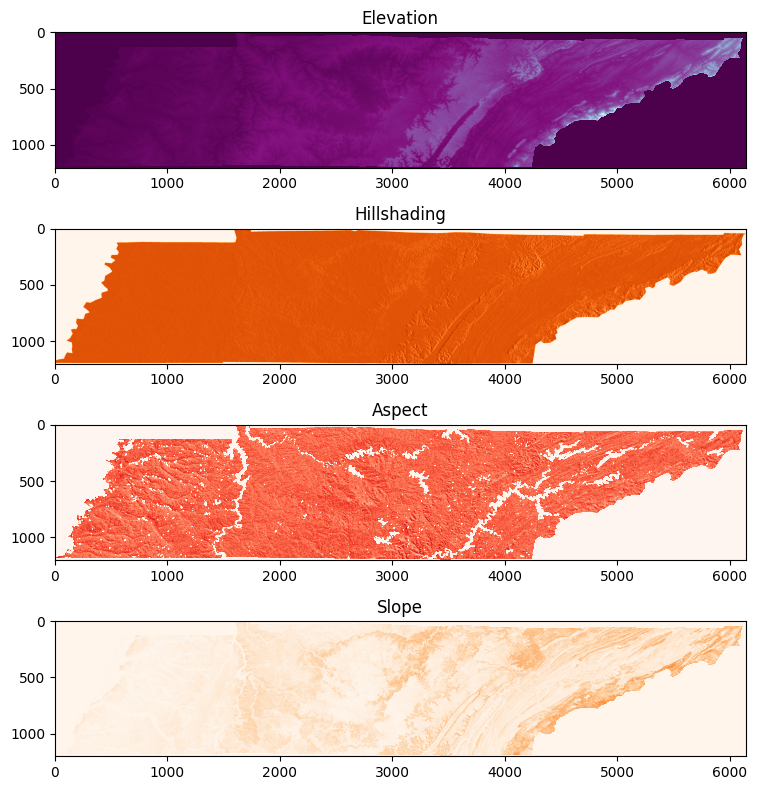

In [108]:
fig,axs=plt.subplots(4,1,figsize=(10,8))
axs[0].imshow(read_elevation,vmin=30,vmax=1999,cmap='BuPu_r')
axs[0].set_title('Elevation')
axs[1].imshow(read_hillshading,vmin=0,vmax=255,cmap='Oranges')
axs[1].set_title('Hillshading')

axs[2].imshow(read_aspect,vmin=0,vmax=360,cmap='Reds')
axs[2].set_title('Aspect')

axs[3].imshow(read_slope,vmin=0,vmax=65.9,cmap='Oranges')
axs[3].set_title('Slope')
plt.subplots_adjust(wspace=0.4,hspace=0.6)
plt.tight_layout()
plt.show()

In [82]:
np.max(read_data)

255

In [111]:
!pip install aws awscli-plugin-endpoint

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 4.4 MB/s eta 0:00:00m eta 0:00:010:01:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.9/11.9 MB 6.9 MB/s eta 0:00:00m eta 0:00:010:01:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 548.2/548.2 kB 12.4 MB/s eta 0:00:00m eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 kB 9.1 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 2.1.0
    Uninstalling urllib3-2.1.0:
      Successfully uninstalled urllib3-2.1.0
  Attempting uninstall: rsa
    Found existing installation: rsa 4.9
    Uninstalling rsa-4.9:
      Successfully uninstalled rsa-4.9
  Attempting uninstall: docutils
    Found existing installation: docutils 0.20.1
    Uninstalling docutils-0.20.1:
      Successfully uninstalled docutils-0.20.1


In [113]:
!aws s3 --profile sealstorage cp Tennessee_terrain_parameters.idx  s3://utah/nsdf/somospie/terrain_tennessee/

upload: ./Tennessee_terrain_parameters.idx to s3://utah/nsdf/somospie/terrain_tennessee/Tennessee_terrain_parameters.idx


In [114]:
!aws s3 --profile sealstorage sync Tennessee_terrain_parameters/  s3://utah/nsdf/somospie/terrain_tennessee/Tennessee_terrain_parameters/

upload: Tennessee_terrain_parameters/0/aspect/0000/0000/0000/000e.bin to s3://utah/nsdf/somospie/terrain_tennessee/Tennessee_terrain_parameters/0/aspect/0000/0000/0000/000e.bin
upload: Tennessee_terrain_parameters/0/aspect/0000/0000/0000/0007.bin to s3://utah/nsdf/somospie/terrain_tennessee/Tennessee_terrain_parameters/0/aspect/0000/0000/0000/0007.bin
upload: Tennessee_terrain_parameters/0/elevation/0000/0000/0000/0007.bin to s3://utah/nsdf/somospie/terrain_tennessee/Tennessee_terrain_parameters/0/elevation/0000/0000/0000/0007.bin
upload: Tennessee_terrain_parameters/0/hillshading/0000/0000/0000/0007.bin to s3://utah/nsdf/somospie/terrain_tennessee/Tennessee_terrain_parameters/0/hillshading/0000/0000/0000/0007.bin
upload: Tennessee_terrain_parameters/0/hillshading/0000/0000/0000/000e.bin to s3://utah/nsdf/somospie/terrain_tennessee/Tennessee_terrain_parameters/0/hillshading/0000/0000/0000/000e.bin
upload: Tennessee_terrain_parameters/0/elevation/0000/0000/0000/000e.bin to s3://utah/nsd

In [ ]:
Tennessee_terrain_parameters/